In [19]:
import sys
sys.path.insert(0, "../kitti/")
from util import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, P2, P2_tf
from util import AVG_HEIGT, AVG_WIDTH, AVG_LENTH
from util import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, KITTI_Object
from util import draw_corner_2D, draw_birdeyes, set_bev_background, init_img_plt, load_tf_image

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

SHOW_COOR = (4, 47)


Most concentrated features pixel has 32.0 anchors
Total anchor in heatmap = 14640.0
There are 0 pixel that don't have anchors
[[3. 3. 3. ... 3. 3. 3.]
 [4. 4. 4. ... 4. 4. 4.]
 [6. 6. 6. ... 6. 6. 6.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]
anchors_tensor.shape = torch.Size([14640, 16])
tensor(14640)
torch.Size([46080])


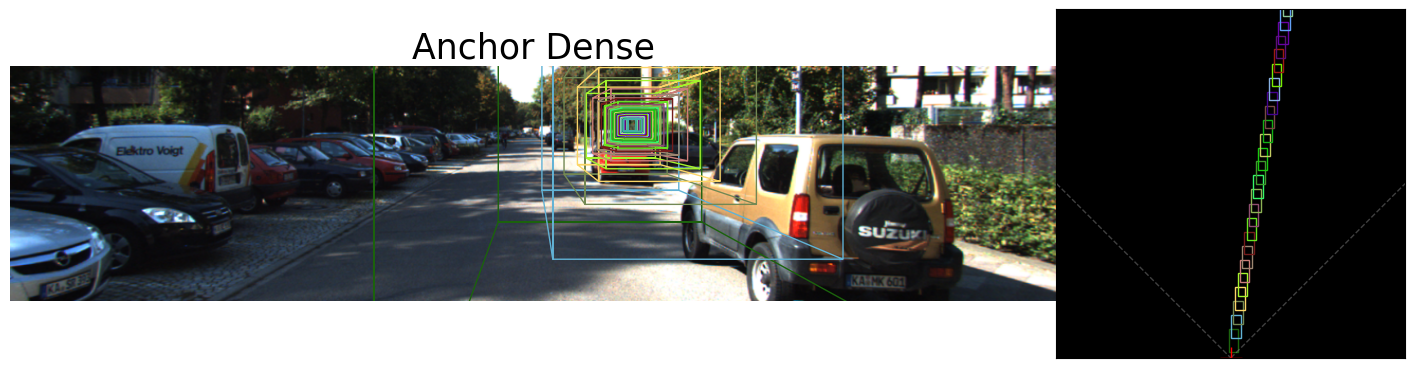

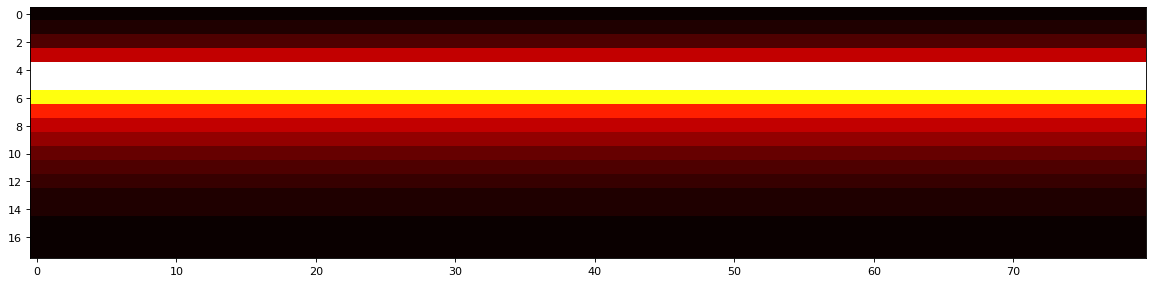

In [20]:
# %%script false --no-raise-error
# anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, 
#                         a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha,
#                         a.x3d, a.y3d, a.z3d, a.rot_y])

img_tf = load_tf_image("/home/lab530/KenYu/kitti/training/image_2/000169.png")
axs = init_img_plt([img_tf], titles = ["Anchor Dense"])

N_ANCHOR_PER_PIXEL = 64

anchors = []
anchors_tensor = []

# print(f"ANCHOR_Y_3D_MEAN + 2*ANCHOR_Y_3D_STD = { ANCHOR_Y_3D_MEAN + 2*ANCHOR_Y_3D_STD}")
# print(f"ANCHOR_Y_3D_MEAN - 4*ANCHOR_Y_3D_STD = { ANCHOR_Y_3D_MEAN - 4*ANCHOR_Y_3D_STD}")
# print(f"GAC's = {(-0.5 + ANCHOR_Y_3D_MEAN, 1.8 + ANCHOR_Y_3D_MEAN)}")

for y_f_idx in range(18):
    for x_f_idx in range(80):
        cx = x_f_idx * 16 + 8
        cy = y_f_idx * 16 + 8
        for cz in np.arange(3.0, 80.0, (80-3)/(N_ANCHOR_PER_PIXEL/2)):
            
            # Convert cx,cy,cz to x3d,y3d,z3d
            loc_3d = np.linalg.inv(P2_tf[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
            loc_3d[1, 0] += AVG_HEIGT / 2.0 

            if 0.0 <= loc_3d[1, 0] <= 3.0: # TODO a heurestic range
                # for rot_y in [0, pi/2]:
                str_line = f"Car NA NA NA NA NA NA NA {AVG_HEIGT} {AVG_WIDTH} {AVG_LENTH} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {rot_y} NA"
                a = KITTI_Object(str_line, is_transform = True, center_2d = (cx,cy,cz))
                # 
                anchors_tensor.append(np.array([a.xmin, a.ymin, a.xmax, a.ymax, 0, a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha, a.x3d, a.y3d, a.z3d, a.rot_y]))
                anchors.append(a)

anchors_tensor = np.array(anchors_tensor)

# Show anchors on specified pixel location
for a in anchors:
    if a.cx_f_index == SHOW_COOR[1] and a.cy_f_index == SHOW_COOR[0]:
        # Draw 
        rnd_color = (random.random(), random.random(), random.random())
        draw_corner_2D(axs[0][0], a.corner_2D, color = rnd_color, is_draw_front = False)
        draw_birdeyes (axs[0][1], a, color = rnd_color)

####
heat_data = np.zeros(shape=(18, 80))
for a in anchors:
    # if 0 <= a.cy_f_index < 18 and 0 <= a.cx_f_index < 80:
    # print(a.cy_f_index, a.cx_f_index)
    heat_data[a.cy_f_index, a.cx_f_index] += 1

print(f"Most concentrated features pixel has {heat_data.max()} anchors" )
print(f"Total anchor in heatmap = {heat_data.sum()}")
print(f"There are {18*80 - np.count_nonzero(heat_data)} pixel that don't have anchors")
print(heat_data)

plt.figure(figsize=(18, 80), dpi=80)
plt.imshow(heat_data, cmap='hot', interpolation='nearest')

########################################
# Convert anchor to tensor 
anchors_tensor = torch.FloatTensor(anchors_tensor)
print(f"anchors_tensor.shape = {anchors_tensor.shape}") # [14284, 12]

# # TODO Don't output 
# with open("anchors_bev_dense.pkl", 'wb') as f:
#     pickle.dump(anchors_tensor, f)
# print(f"Write anchor result to anchors_bev_dense.pkl")

# Get heat_data
max_n_anchor = int(heat_data.max())
anchor_map = []
for i in range(18):
    for j in range(80):
        anchor_map += ( [True for _ in range(int(heat_data[i, j]))] + [False for _ in range(max_n_anchor - int(heat_data[i, j]))] )
anchor_map = torch.tensor(anchor_map)

print( torch.count_nonzero(anchor_map) )
print( anchor_map.shape ) # [92160] 28800 trues

# TODO Don't output 
# with open("anchor_bev_dense_map.pkl", 'wb') as f:
#     pickle.dump(anchor_map, f)
# print(f"Write anchor result to anchor_bev_dense_map.pkl")